In [1]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)      # input resolution (H, W)
NUM_SAMPLES = 20000         # use only 20k pairs
BATCH_SIZE = 2              # small batch to avoid OOM
EPOCHS = 25
CHECKPOINT_PATH = "best_vit_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠️ GPU memory growth setup failed:", e)
else:
    print("⚠️ No GPU found, training on CPU")

# ----------------------------
# Helper: list & sample indices
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    print(f"Total available pairs: {total}")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Using {len(train_indices)} train and {len(val_indices)} val samples (total {num_chosen})")

# ----------------------------
# Streaming data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping file due to error:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            Xb = np.stack(Xb, axis=0).astype(np.float32)
            Yb = np.stack(Yb, axis=0).astype(np.float32)
            yield Xb, Yb

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# Memory-safe ViT segmentation model
# ----------------------------
def vit_segmentation_model_safe(
    image_size=(128,128,1),
    patch_size=16,
    embed_dim=128,
    num_heads=4,
    mlp_dim=256,
    num_layers=4,
    decoder_filters=32,
    dropout_rate=0.1
):
    H, W, C = image_size
    assert H % patch_size == 0 and W % patch_size == 0, "image dims must be divisible by patch_size"
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w

    inputs = layers.Input(shape=(H, W, C), name="image_input")

    # Patch embedding via Conv2D stride=patch_size
    x = layers.Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, embed_dim))(x)

    # Positional embedding
    pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos = pos_emb(positions)
    x = x + pos

    # Transformer encoder
    for i in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads, dropout=dropout_rate)(x1, x1)
        x = layers.Add()([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        mlp = layers.Dense(mlp_dim, activation='gelu')(x2)
        mlp = layers.Dropout(dropout_rate)(mlp)
        mlp = layers.Dense(embed_dim)(mlp)
        mlp = layers.Dropout(dropout_rate)(mlp)
        x = layers.Add()([x, mlp])

    # Reshape to 2D grid
    x = layers.Reshape((num_patches_h, num_patches_w, embed_dim))(x)

    # Light Conv decoder with upsampling
    x = layers.Conv2D(decoder_filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(decoder_filters, patch_size, strides=patch_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ViT_Segmenter_Safe")
    return model

model = vit_segmentation_model_safe(image_size=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
cb_earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop],
    verbose=1
)

# ----------------------------
# Metrics helpers
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# ----------------------------
# Evaluate on validation set
# ----------------------------
print("\n🔍 Running evaluation on validation set (streaming)...")
y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)
for _ in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb)
    y_trues.append(Yb)
    y_preds_probs.append(preds)

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)
n_val = min(y_trues.shape[0], y_preds_probs.shape[0])
y_trues = y_trues[:n_val]
y_preds_probs = y_preds_probs[:n_val]

y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except ValueError:
    auc = float('nan')

dice_list, iou_list = [], []
for i in range(n_val):
    gt = (y_trues[i].squeeze() > 0.5).astype(np.float32)
    pr = (y_preds_probs[i].squeeze() > 0.5).astype(np.float32)
    dice_list.append(dice_coef_np(gt, pr))
    iou_list.append(iou_np(gt, pr))

print("\n📊 Validation Metrics:")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"AUC-ROC   : {auc if not np.isnan(auc) else 'N/A'}")
print(f"Mean Dice : {np.mean(dice_list):.4f}")
print(f"Mean IoU  : {np.mean(iou_list):.4f}")

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Show sample predictions
# ----------------------------
print(f"\nShowing {PRED_SAMPLES_TO_SHOW} sample predictions from validation set...")
n_show = min(PRED_SAMPLES_TO_SHOW, n_val)
fig, axs = plt.subplots(n_show, 3, figsize=(10, 4*n_show))
for i in range(n_show):
    gt = y_trues[i].squeeze()
    prob = y_preds_probs[i].squeeze()
    pred_bin = (prob > 0.5).astype(np.uint8)

    idx_in_list = val_indices[i]
    input_img_path = os.path.join(IMAGE_DIR, imgs_list[idx_in_list])
    input_img = cv2.imread(input_img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, IMG_SIZE) / 255.0

    axs[i,0].imshow(input_img, cmap='gray'); axs[i,0].set_title('Input')
    axs[i,1].imshow(gt, cmap='gray'); axs[i,1].set_title('Ground Truth Mask')
    axs[i,2].imshow(pred_bin, cmap='gray'); axs[i,2].set_title('Predicted Mask')
    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

print("\n✅ Training & evaluation complete. Best checkpoint (if saved) is at:", CHECKPOINT_PATH)


✅ GPU memory growth enabled
Total available pairs: 58620
Using 16000 train and 4000 val samples (total 20000)
Steps per epoch: 8000 Validation steps: 2000
Model: "ViT_Segmenter_Safe"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 128)    32896       ['image_input[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 64, 128)      0           ['conv2d[0][0]']                 
                         

: 

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 16000 Validation steps: 4000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     16448       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 64, 64)       0           ['conv2d[0][0]']                 
                                                                                 

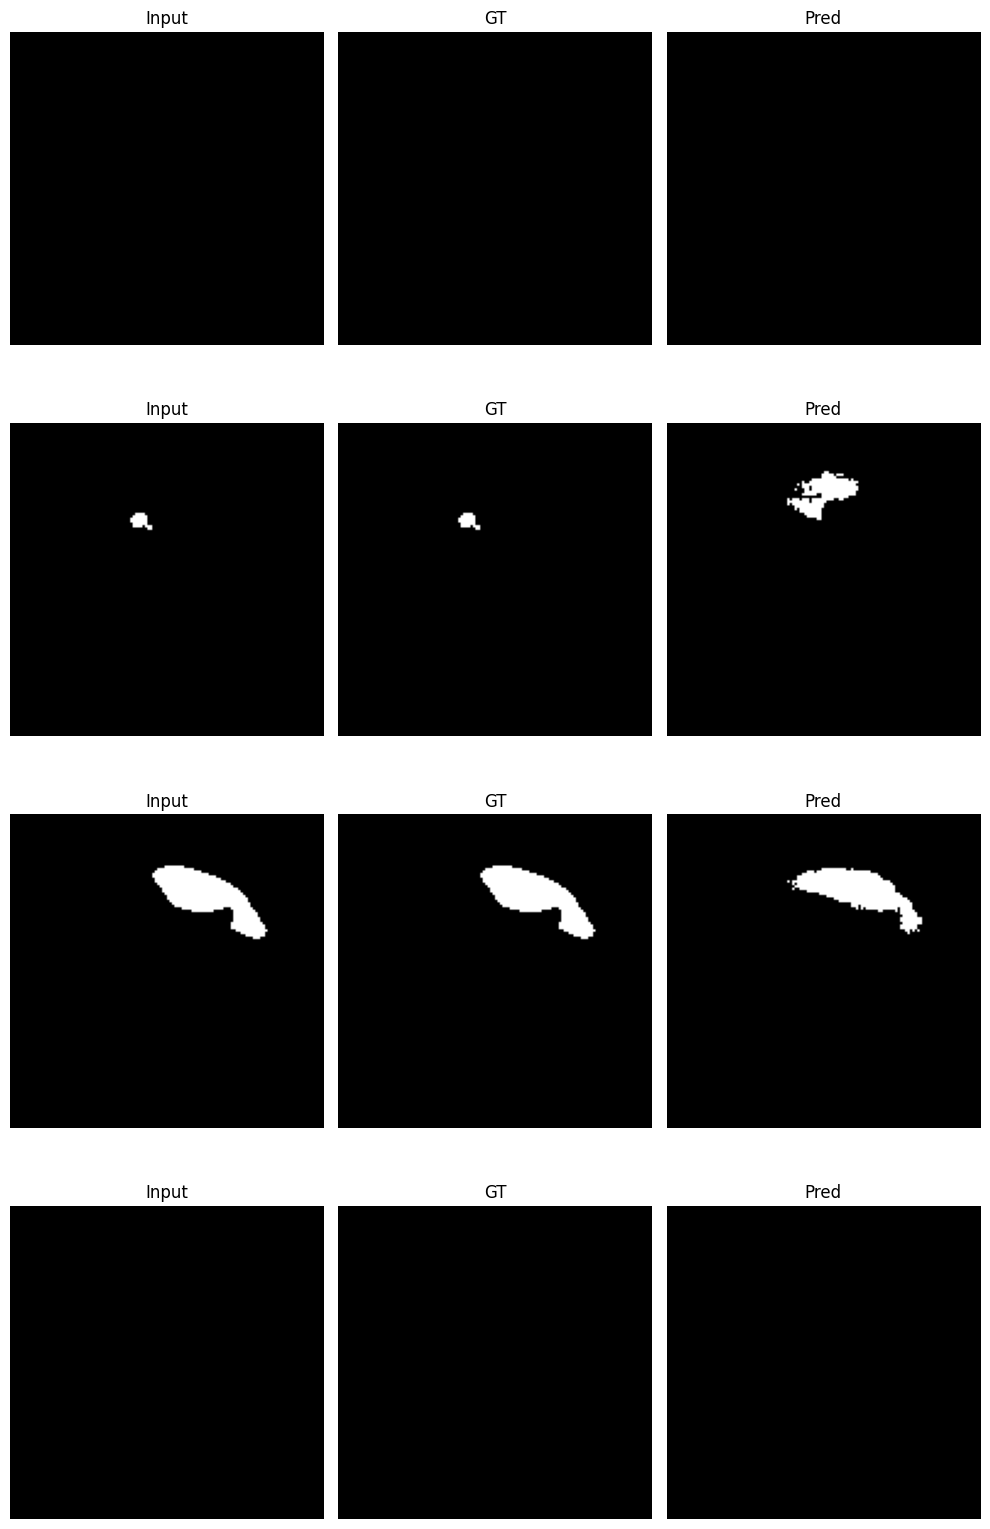

✅ Training & evaluation complete. Best checkpoint at: best_vit_checkpoint.h5


In [1]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 20000
BATCH_SIZE = 1          # extremely small to prevent OOM
EPOCHS = 25
CHECKPOINT_PATH = "best_vit_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠️ GPU memory growth failed:", e)
else:
    print("⚠️ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

def vit_seg_model(image_size=(128,128,1), patch_size=16, embed_dim=64, num_heads=2, mlp_dim=128, num_layers=2):
    H, W, C = image_size
    num_patches = (H//patch_size)*(W//patch_size)
    
    inputs = layers.Input(shape=image_size)
    # Patch embedding
    x = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, embed_dim))(x)

    # Positional embedding
    pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(num_patches)
    x = x + pos_emb(positions)

    # Transformer blocks
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)(x1, x1)
        x = layers.Add()([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        mlp = layers.Dense(mlp_dim, activation='gelu')(x2)
        mlp = layers.Dense(embed_dim)(mlp)
        x = layers.Add()([x, mlp])

    # Reshape to 2D
    x = layers.Reshape((H//patch_size, W//patch_size, embed_dim))(x)
    # Simple Conv decoder
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, patch_size, strides=patch_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)

    return models.Model(inputs, outputs)

model = vit_seg_model(image_size=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
cb_earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ----------------------------
# Train
# ----------------------------
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=val_gen, validation_steps=validation_steps,
                    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop])

# ----------------------------
# Evaluation
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)
for _ in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb)
    y_trues.append(Yb)
    y_preds_probs.append(preds)

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat>0.5).astype(np.uint8)

precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

dice = np.mean([dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])])
iou = np.mean([iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc}, Dice: {dice:.4f}, IoU: {iou:.4f}")

# ---- sample predictions
# ----------------------------------------------------
# Plot
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show,3,figsize=(10,4*n_show))
for i in range(n_show):
    input_img = y_trues[i].squeeze()
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze()>0.5).astype(np.uint8)
    axs[i,0].imshow(input_img,cmap='gray'); axs[i,0].set_title('Input')
    axs[i,1].imshow(gt,cmap='gray'); axs[i,1].set_title('GT')
    axs[i,2].imshow(pred,cmap='gray'); axs[i,2].set_title('Pred')
    for ax in axs[i]: ax.axis('off')
plt.tight_layout()
plt.show()

print("✅ Training & evaluation complete. Best checkpoint at:", CHECKPOINT_PATH)


✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 16000 Validation steps: 4000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     16448       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 64, 64)       0           ['conv2d[0][0]']                 
                                                                                 

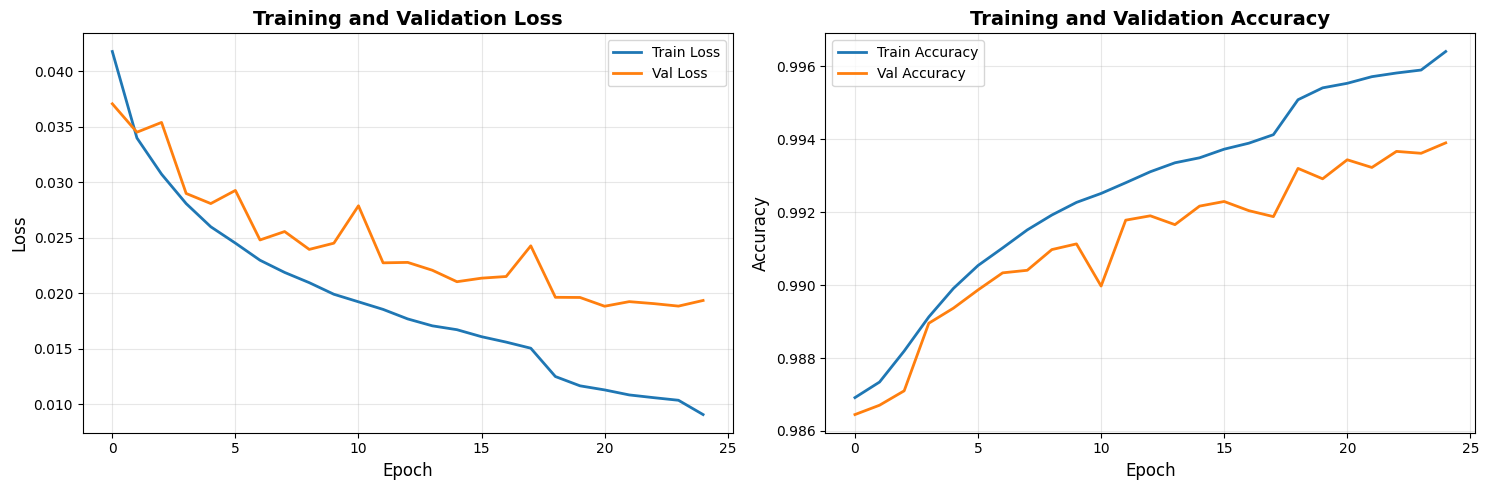


MODEL EVALUATION

Metrics:
  Precision: 0.8459
  Recall:    0.6798
  F1 Score:  0.7538
  AUC:       0.9942
  Dice:      0.8132
  IoU:       0.7870

CONFUSION MATRIX


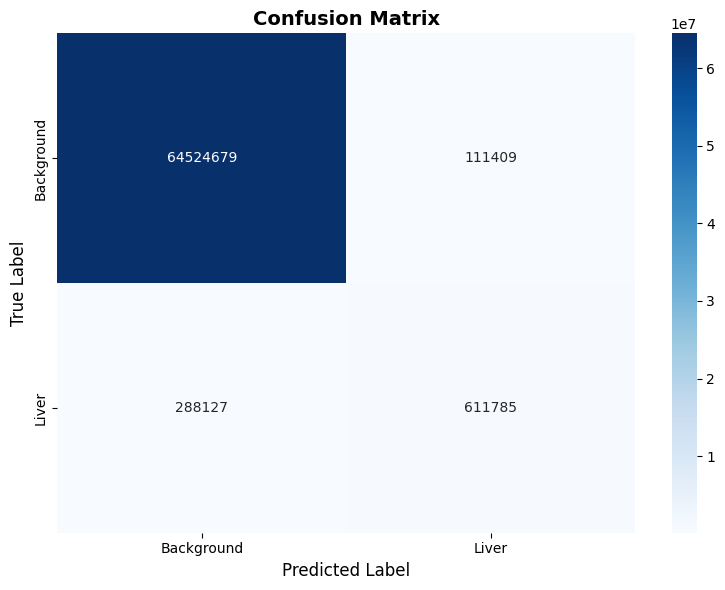


Confusion Matrix:
[[64524679   111409]
 [  288127   611785]]
  TN: 64524679, FP: 111409
  FN: 288127, TP: 611785

ROC CURVE


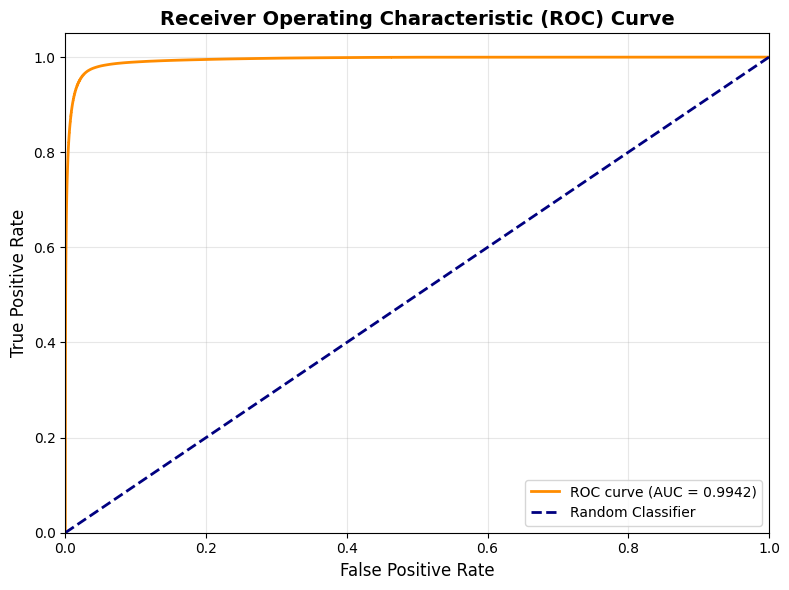


SAMPLE PREDICTIONS


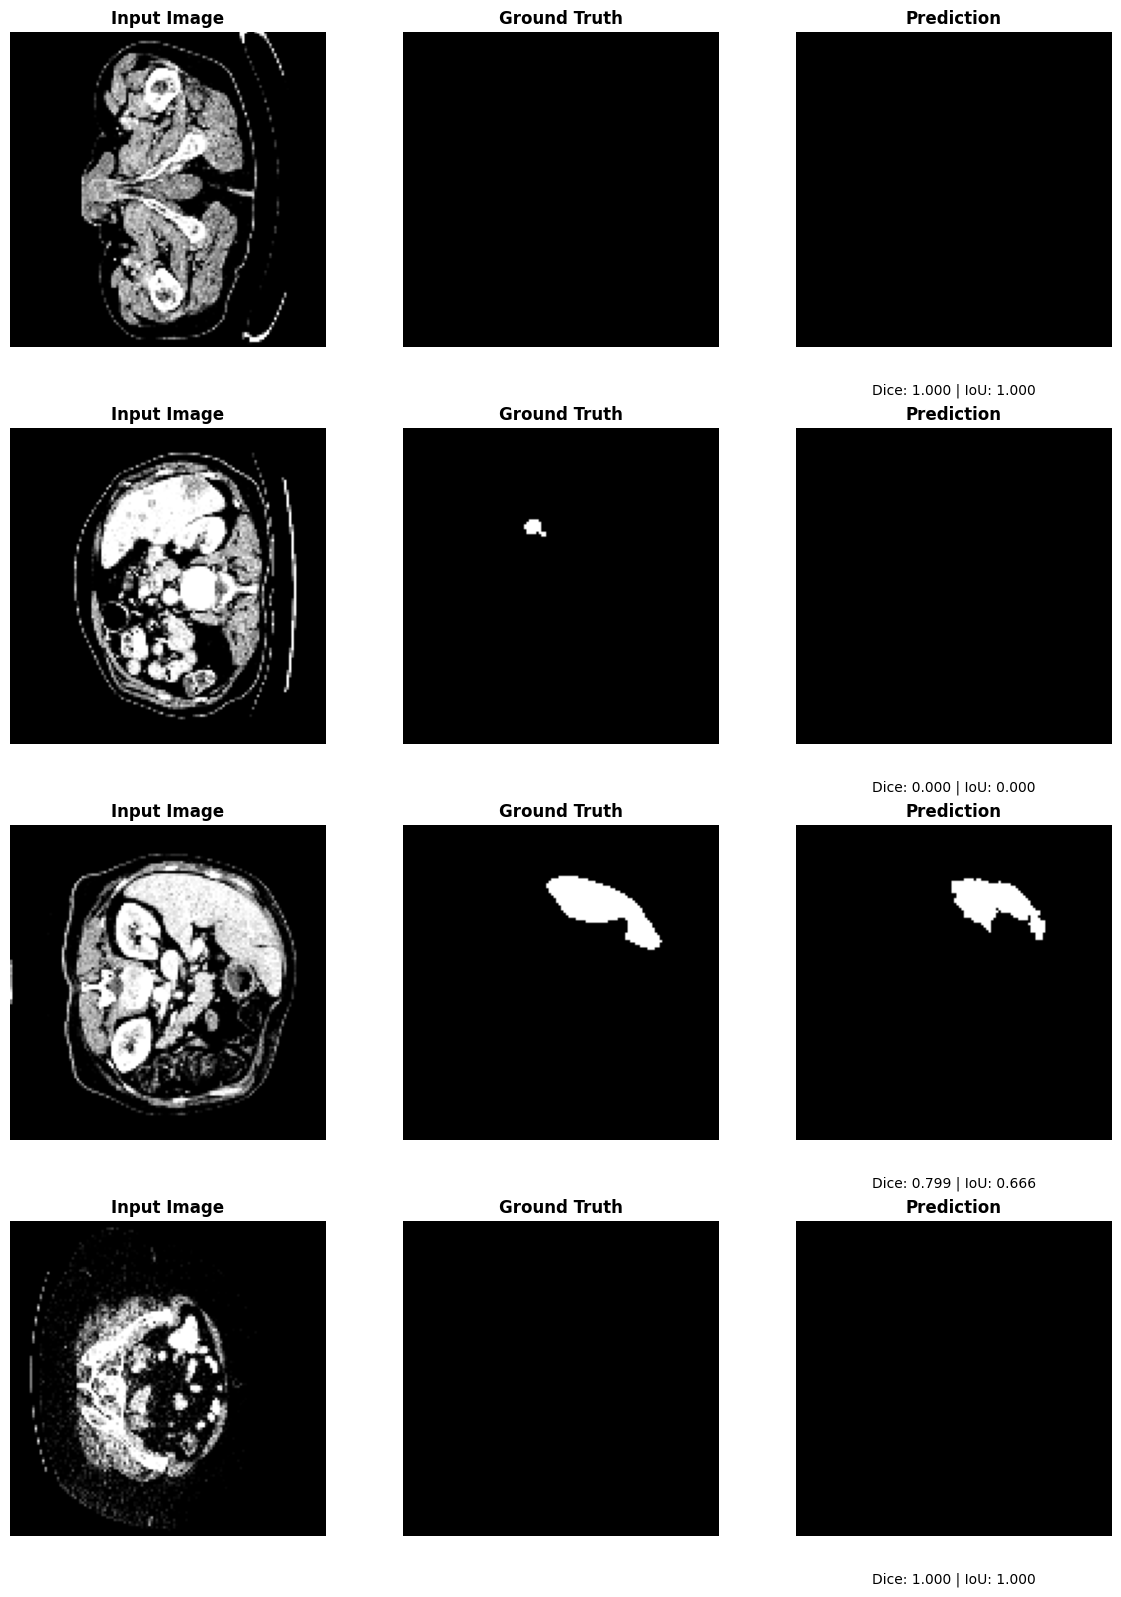


TRAINING COMPLETE
✅ Best checkpoint saved at: best_vit_checkpoint.h5
✅ Visualizations saved:
   - training_curves.png
   - confusion_matrix.png
   - roc_curve.png
   - sample_predictions.png


In [1]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 20000
BATCH_SIZE = 1          # extremely small to prevent OOM
EPOCHS = 25
CHECKPOINT_PATH = "best_vit_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

def vit_seg_model(image_size=(128,128,1), patch_size=16, embed_dim=64, num_heads=2, mlp_dim=128, num_layers=2):
    H, W, C = image_size
    num_patches = (H//patch_size)*(W//patch_size)
    
    inputs = layers.Input(shape=image_size)
    # Patch embedding
    x = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding='valid')(inputs)
    x = layers.Reshape((num_patches, embed_dim))(x)

    # Positional embedding
    pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(num_patches)
    x = x + pos_emb(positions)

    # Transformer blocks
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)(x1, x1)
        x = layers.Add()([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        mlp = layers.Dense(mlp_dim, activation='gelu')(x2)
        mlp = layers.Dense(embed_dim)(mlp)
        x = layers.Add()([x, mlp])

    # Reshape to 2D
    x = layers.Reshape((H//patch_size, W//patch_size, embed_dim))(x)
    # Simple Conv decoder
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, patch_size, strides=patch_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)

    return models.Model(inputs, outputs)

model = vit_seg_model(image_size=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
cb_earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ----------------------------
# Train
# ----------------------------
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=val_gen, validation_steps=validation_steps,
                    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop])

# ----------------------------
# Plot Training Curves
# ----------------------------
print("\n" + "="*60)
print("TRAINING CURVES")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Evaluation
# ----------------------------
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)
for _ in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat>0.5).astype(np.uint8)

precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

dice = np.mean([dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])])
iou = np.mean([iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])])

print(f"\nMetrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  AUC:       {auc:.4f}")
print(f"  Dice:      {dice:.4f}")
print(f"  IoU:       {iou:.4f}")

# ----------------------------
# Confusion Matrix
# ----------------------------
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:\n{cm}")
print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")

# ----------------------------
# ROC Curve
# ----------------------------
print("\n" + "="*60)
print("ROC CURVE")
print("="*60)

fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_prob_flat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Sample Predictions
# ----------------------------
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 3, figsize=(12, 4*n_show))

# Handle single row case
if n_show == 1:
    axs = axs.reshape(1, -1)

for i in range(n_show):
    # Get corresponding input image
    idx = val_indices[i]
    img_path = os.path.join(IMAGE_DIR, imgs_list[idx])
    input_img = preprocess_image(img_path, IMG_SIZE).squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze()>0.5).astype(np.uint8)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title('Input Image', fontsize=12, fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontsize=12, fontweight='bold')
    
    # Calculate metrics for this sample
    sample_dice = dice_coef_np(gt, pred)
    sample_iou = iou_np(gt, pred)
    axs[i,2].text(0.5, -0.15, f'Dice: {sample_dice:.3f} | IoU: {sample_iou:.3f}',
                  transform=axs[i,2].transAxes, ha='center', fontsize=10)
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"✅ Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"✅ Visualizations saved:")
print(f"   - training_curves.png")
print(f"   - confusion_matrix.png")
print(f"   - roc_curve.png")
print(f"   - sample_predictions.png")
print("="*60)